In [79]:
import os, io
from pathlib import Path
import math
from operator import itemgetter
from collections import defaultdict, namedtuple, Counter, deque
from heapq import heapify, heappush, heappop
from itertools import chain
from dataclasses import dataclass, field
import operator
import itertools
import sqlite3
import logging
import logging.handlers
import multiprocessing as mp
import pickle

from tqdm.notebook import tqdm
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance

import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from scipy.interpolate import RegularGridInterpolator

from utils import *
from hdc import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

hdc = Hdc(config.hdc_n, np)

xp = numpy


In [3]:
def ensure_dataset_folder():
    if not os.path.exists(config.dataset_path):
        print(f'Creating "{config.dataset_path}"')
        os.mkdir(config.dataset_path)

def is_table_exists(db_con, table_name):
    df = pd.read_sql('SELECT name FROM sqlite_master WHERE type=:type AND name=:table_name', params={'type': 'table', 'table_name': table_name}, con=db_con)
    return len(df) > 0

def is_table_empty(db_con, table_name):
    cur = train_db_con.cursor() 
    return len(cur.execute(f'SELECT * FROM {table_name} LIMIT 1').fetchall()) < 1

def drop_table_safe(db_con, tn):
    if is_table_exists(db_con, tn):
        db_con.cursor().execute(f'DROP TABLE {tn}')
        db_con.commit()

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

ensure_dataset_folder()
train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name), autocommit=False)
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name), autocommit=False)

# Load MNIST

In [4]:
dataset_source = os.path.join(config.dataset_source)

In [5]:
import struct
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

CPU times: user 168 ms, sys: 59.3 ms, total: 228 ms
Wall time: 227 ms


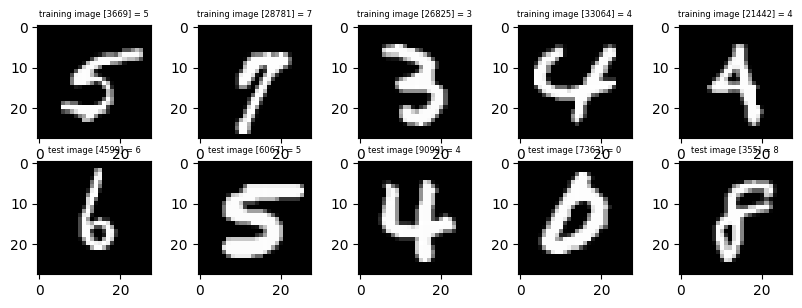

In [6]:
%%time
import random

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = os.path.join(dataset_source, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(dataset_source, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(dataset_source, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(dataset_source, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,5))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 6);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Create dataset

In [195]:
%run sequencing_sp2.ipynb

In [196]:
ImageRec = namedtuple('ImageRec', ['image_id', 'value', 'png', 'image'])
SequenceImageTask = namedtuple('SequenceImageTask', ['image_id', 'sense_vector'])
SequenceImageTaskResult = namedtuple('SequenceImageTaskResult', ['image_id', 'outer_si_ind_dict', 'inner_si_ind_dict', 'outer_sequences', 'inner_sequences', 'inner_xy_sequence', 'inner_vec_sequence'])

def mp_sequence_image(task):
    try:
        seq_context = parse_sense_vector(task.sense_vector)
        seq_context = get_outer_grooves(seq_context)
        seq_context = get_inner_grooves(seq_context)
        seq_context = get_outer_raw_sequences(seq_context)
        seq_context = get_outer_sequences(seq_context)
        seq_context = ccw_orient_outer_sequences(seq_context)
        seq_context = get_inner_segments(seq_context)
        seq_context = get_inner_seg_sequences(seq_context)
    except Exception as ex:
        print(f'Failed to sequence image {task.image_id}')
        raise

    # turn to single sequence
    inner_sequence = itertools.chain.from_iterable(seq_context.inner_seg_sequences)
    fetch_xy = lambda si: (si.x, si.y)
    # convert sequence of si_inds -> sequence of (x, y)
    inner_xy_sequence = np.array(list(map(lambda si_ind: fetch_xy(seq_context.inner_si_ind_dict[si_ind]), inner_sequence)))
    # turn to vector sequence
    inner_vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), zip(inner_xy_sequence, np.vstack([inner_xy_sequence[1:], inner_xy_sequence[:1]])))))
        
    return SequenceImageTaskResult(image_id=task.image_id, 
                                   outer_si_ind_dict=export_si_ind_dict(seq_context.outer_si_ind_dict),
                                   inner_si_ind_dict=export_si_ind_dict(seq_context.inner_si_ind_dict),
                                   outer_sequences=seq_context.outer_sequences, 
                                   inner_sequences=seq_context.inner_seg_sequences,
                                   inner_xy_sequence=inner_xy_sequence,
                                   inner_vec_sequence=inner_vec_sequence)

def create_dataset(image_indices, x_dataset, y_dataset, samples_count, id_offset):
    image_dataset = defaultdict(list)
    image_recs = {} # key - image_id, value - ImageRec instance. Instances are stored for the time they are being processed via pool
    batch_size = max(4, mp.cpu_count() - 1)

    def run_pending_tasks(async_task_results, task_image_ids, is_drain=False):
        cycles = 2 if is_drain else 1

        for _ in range(cycles):
            task_results = async_task_results.get() if async_task_results else None

            if task_image_ids:
                images = list(map(lambda image_id: image_recs[image_id].image, task_image_ids))
                images_matrix = np.vstack(images)
                images_matrix = xp_array_to_gpu(images_matrix)
                sense_vectors = sense_images(images_matrix)
                tasks = map(lambda v: SequenceImageTask(image_id=v[0], sense_vector=xp_array_from_gpu(v[1])), zip(task_image_ids, sense_vectors))
                async_task_results = pool.map_async(mp_sequence_image, tasks)
                task_image_ids = None
            else:
                async_task_results = None
    
            if task_results:
                # While new tasks are being executed we persist data from previous run
                for task_result in task_results:
                    assert task_result.image_id in image_recs
                    image_rec = image_recs[task_result.image_id]
                    image_dataset['image_id'].append(task_result.image_id)
                    image_dataset['value'].append(image_rec.value)
                    image_dataset['png'].append(image_rec.png)
                    image_dataset['outer_si_ind_dict'].append(pickle.dumps(task_result.outer_si_ind_dict))
                    image_dataset['inner_si_ind_dict'].append(pickle.dumps(task_result.inner_si_ind_dict))
                    image_dataset['outer_sequences'].append(pickle.dumps(task_result.outer_sequences))
                    image_dataset['inner_sequences'].append(pickle.dumps(task_result.inner_sequences))
                    image_dataset['inner_xy_sequence'].append(pickle.dumps(task_result.inner_xy_sequence))
                    image_dataset['inner_vec_sequence'].append(pickle.dumps(task_result.inner_vec_sequence))
    
        return async_task_results

    with mp.Pool(processes=batch_size) as pool:
        async_task_result = None
        task_image_ids = []
        
        for i in tqdm(image_indices):
            with Image.frombytes('L', size=(28, 28), data=x_dataset[i]) as img:
                img = resize_original_image(img)
                b = io.BytesIO()
                img.save(b, format='PNG')
                png = b.getvalue()
                image = xp.array(img).ravel()

            image_id = i + id_offset
            task_image_ids.append(image_id)
            image_recs[image_id] = ImageRec(image_id=image_id, value=str(y_dataset[i]), png=png, image=image)

            if len(task_image_ids) >= batch_size:
                async_task_result = run_pending_tasks(async_task_result, task_image_ids)
                task_image_ids = []
        
        # Complete pending tasks and drain remaining
        run_pending_tasks(async_task_result, task_image_ids, is_drain=True)

    image_dataset = pd.DataFrame(image_dataset)
    return image_dataset

def save_dataset(image_dataset, db_con):
    image_dataset.to_sql(name='images', con=db_con)

    cur = db_con.cursor()
    cur.execute('CREATE INDEX ix_images_image_id ON images(image_id)')
    db_con.commit()

In [211]:
old_image_indices = {}

for db_con, db_con_nold_image_indicesame in [(train_db_con, 'train'), (test_db_con, 'test')]:
    if is_table_exists(db_con, 'images'):
        old_image_indices[db_con_name] = pd.read_sql('SELECT image_id FROM images', con=db_con, index_col='image_id')

In [210]:
if True:
# if False:
    train_tuple = (train_db_con, x_train, y_train, config.dataset_train_samples_count, 0)
    test_tuple = (test_db_con, x_test, y_test, config.dataset_test_samples_count, 100_000_000)
    
    for db_con, x, y, samples_count, id_offset in [train_tuple, test_tuple]:
        drop_table_safe(db_con, 'images')
        db_con.commit()

In [212]:
%%time
train_tuple = (train_db_con, 'train', x_train, y_train, config.dataset_train_samples_count, 0)
test_tuple = (test_db_con, 'test', x_test, y_test, config.dataset_test_samples_count, 100_000_000)

for db_con, db_con_name, x, y, samples_count, id_offset in [train_tuple, test_tuple]:
    if not is_table_exists(db_con, 'images'):
        if db_con_name in old_image_indices:
            image_indices = list(old_image_indices[db_con_name].index)
        else:
            image_indices = RNG.choice(len(x), samples_count, replace=False)
        
        # image_indices = [2595]
        image_dataset = create_dataset(image_indices, x, y, samples_count, id_offset)
        save_dataset(image_dataset, db_con)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 1min 9s, sys: 1min 34s, total: 2min 44s
Wall time: 2min 10s


# Verify dataset


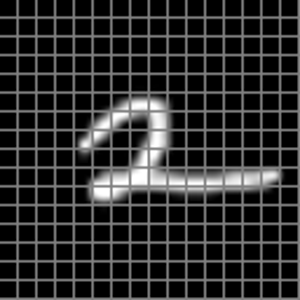
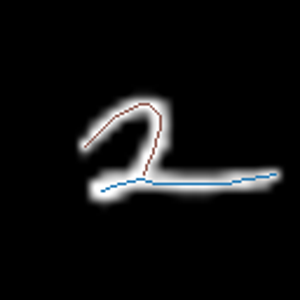
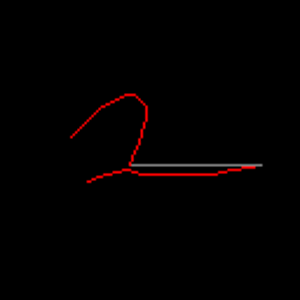
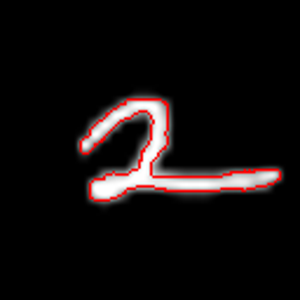
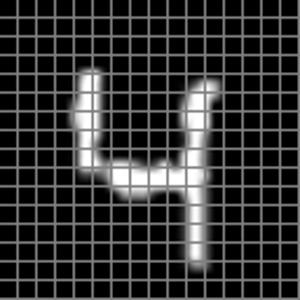
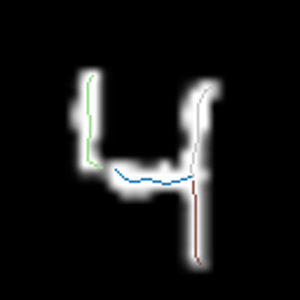
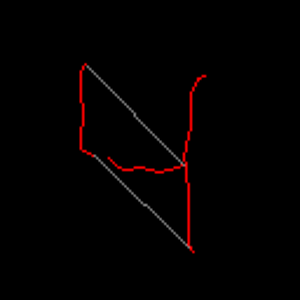
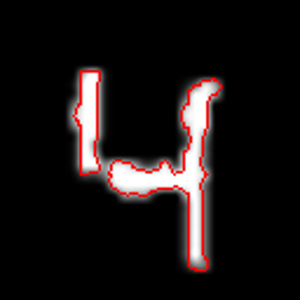
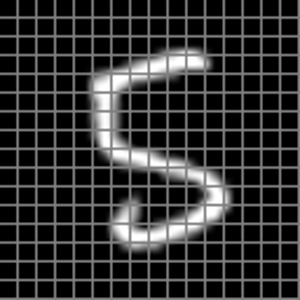
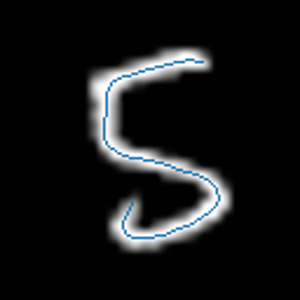
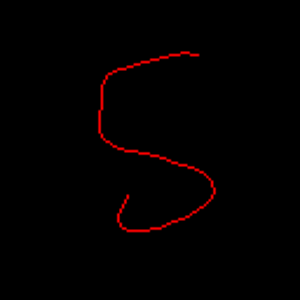
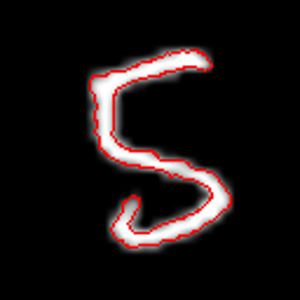
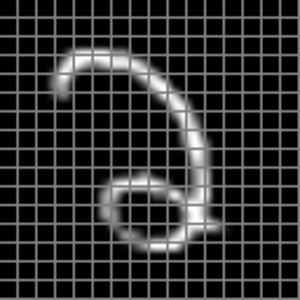
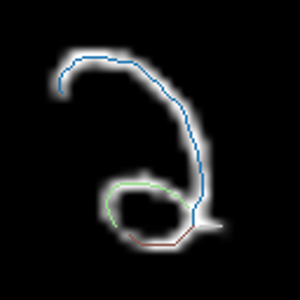
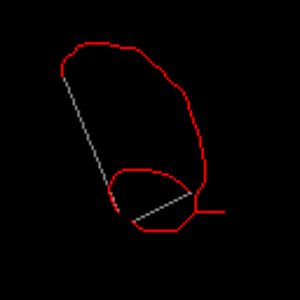
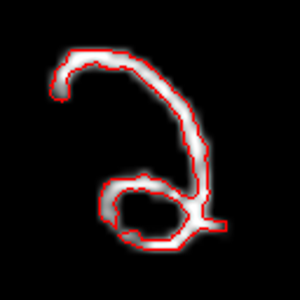
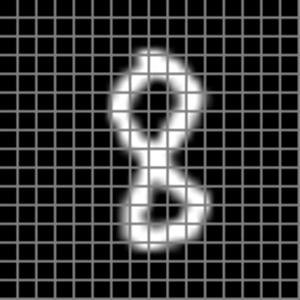
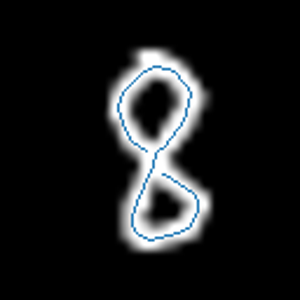
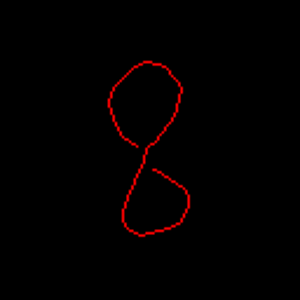
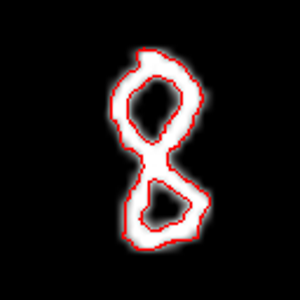
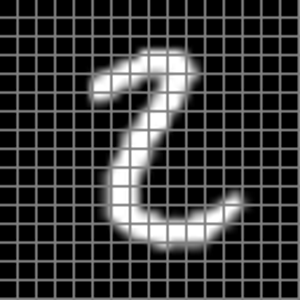
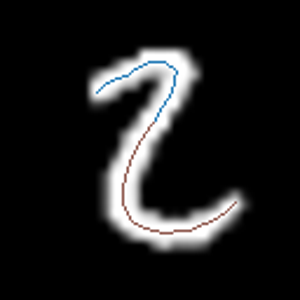
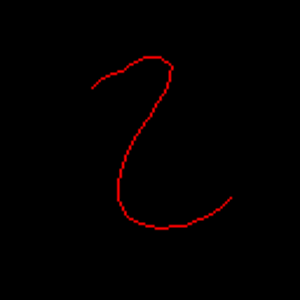
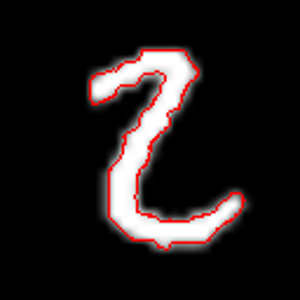
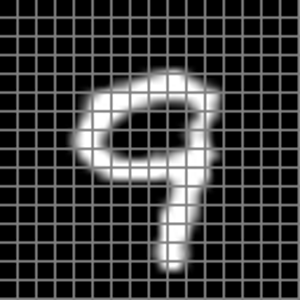
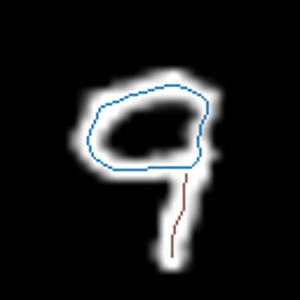
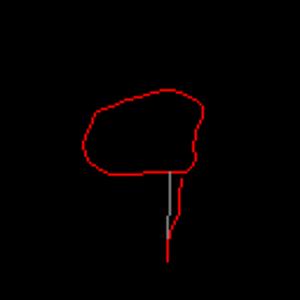
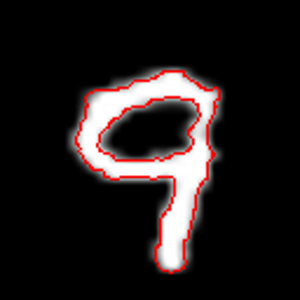
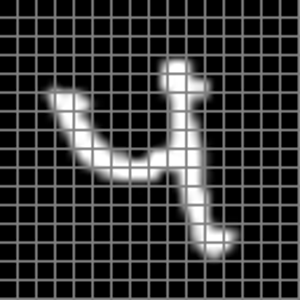
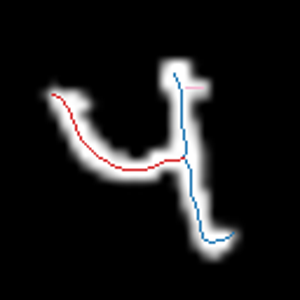
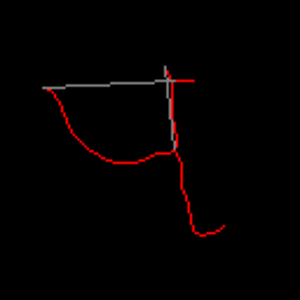
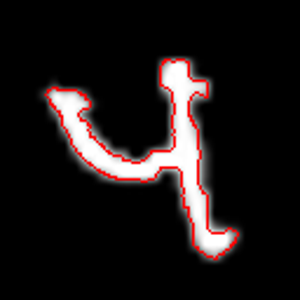
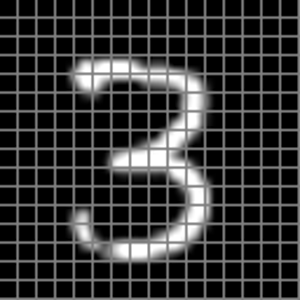
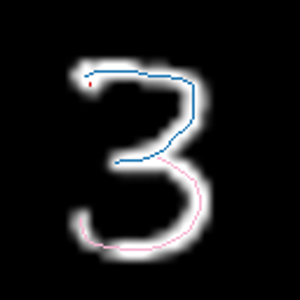
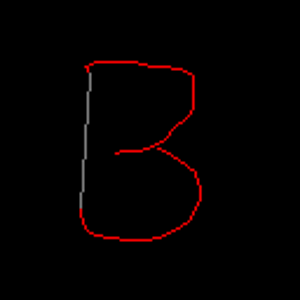
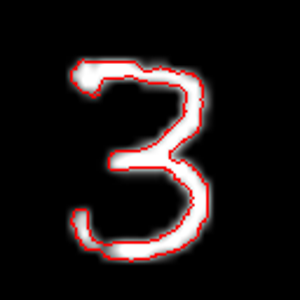
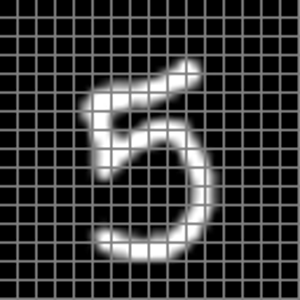
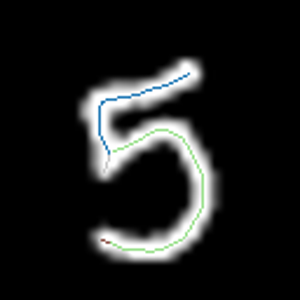
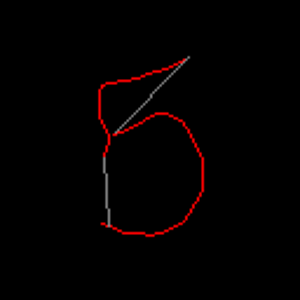
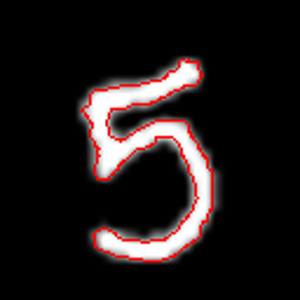

In [213]:
empty_image = Image.new('L', size=(1,1), color=255)
lay_grid_local = lambda i: lay_grid(i, 8)

images = []
captions = []

df_image_ids = pd.read_sql_query('SELECT image_id FROM images', con=train_db_con, index_col='image_id')
image_ids = RNG.choice(df_image_ids.index.unique(), 10, replace=False)
# image_ids = [5183] # 8 with nasty adornment
# image_ids = [42133] 

for image_id in image_ids:
    # Image as-is
    df_images = pd.read_sql_query('SELECT value, png, inner_si_ind_dict, outer_si_ind_dict, inner_sequences, inner_xy_sequence, inner_vec_sequence, outer_sequences FROM images WHERE image_id=:image_id', 
                                  con=train_db_con, params={'image_id': int(image_id)})
    assert len(df_images) == 1
    image_data = df_images.iloc[0]['png']
    image = Image.open(io.BytesIO(image_data))
    images.append(lay_grid_local(image.copy()))
    captions.append(f'{image_id}, val={df_images.iloc[0]['value']}')
    
    inner_si_ind_dict = pickle.loads(df_images.iloc[0]['inner_si_ind_dict'])
    outer_si_ind_dict = pickle.loads(df_images.iloc[0]['outer_si_ind_dict'])
    inner_sequences = pickle.loads(df_images.iloc[0]['inner_sequences'])
    inner_xy_sequence = pickle.loads(df_images.iloc[0]['inner_xy_sequence'])
    inner_vec_sequence = pickle.loads(df_images.iloc[0]['inner_vec_sequence'])
    outer_sequences = pickle.loads(df_images.iloc[0]['outer_sequences'])
    
    # Inner sequences
    iseq_color_map = mpl.colormaps['tab20']
    image_pil = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=np.array(image).ravel())
    image_pil = image_pil.convert('RGB')
    draw = ImageDraw.Draw(image_pil)
    pts_count = 0
    
    for seq_i, seq in enumerate(inner_sequences):
        for si_ind_from, si_ind_to in zip(seq, seq[1:]):
            si_from = inner_si_ind_dict[si_ind_from]
            si_to = inner_si_ind_dict[si_ind_to]
            pt_from = si_from.x, si_from.y
            pt_to = si_to.x, si_to.y
            color = iseq_color_map(seq_i / len(inner_sequences), bytes=True)
            draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill=color)
        
        pts_count += len(seq)
    
    images.append(image_pil)
    captions.append(f'{len(inner_sequences)} inner seqs, {pts_count} pts')

    # Inner vec sequence
    xy_list = [(0, 0)]
    
    for vec in inner_vec_sequence[:-1]:
        xy_list.append((xy_list[-1][0] + vec[0], xy_list[-1][1] + vec[1]))

    xy_list = np.array(xy_list).astype('f')
    xy_mean = np.mean(xy_list, axis=0)
    xy_list -= xy_mean
    
    image_pil = Image.new('L', size=(config.sample_size, config.sample_size), color='black')
    image_pil = image_pil.convert('RGB')
    draw = ImageDraw.Draw(image_pil)

    xy_list = np.hstack([xy_list, np.roll(xy_list, -1, axis=0)])
    
    for xy_list_row, vec in zip(xy_list[:-1], inner_vec_sequence):
        pt_from = xy_list_row[0] + config.sample_size / 2, xy_list_row[1] + config.sample_size / 2
        pt_to = xy_list_row[2] + config.sample_size / 2, xy_list_row[3] + config.sample_size / 2
        color = 'red' if np.linalg.norm(vec) < 10 else 'gray'
        draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill=color)
        
    images.append(image_pil)
    captions.append(f'{len(inner_sequences)} inner vec seq, {xy_list.shape[0]} pts')
    
    # Outer sequences
    image_pil = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=np.array(image).ravel())
    image_pil = image_pil.convert('RGB')
    draw = ImageDraw.Draw(image_pil)
    full_seq_pts_count = 0
    
    for seq in outer_sequences:
        for si_ind_from, si_ind_to in zip(seq, seq[1:] + seq[:1]):
            si_from = outer_si_ind_dict[si_ind_from]
            si_to = outer_si_ind_dict[si_ind_to]
            pt_from = si_from.x, si_from.y
            pt_to = si_to.x, si_to.y
            draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')
    
        full_seq_pts_count += len(seq)
    
    images.append(image_pil)
    captions.append(f'{len(outer_sequences)} outer seqs, {full_seq_pts_count} pts')
    
display_images_grid(list(map(lambda i: i.resize((300, 300)), images)), captions=captions, col_count=4)

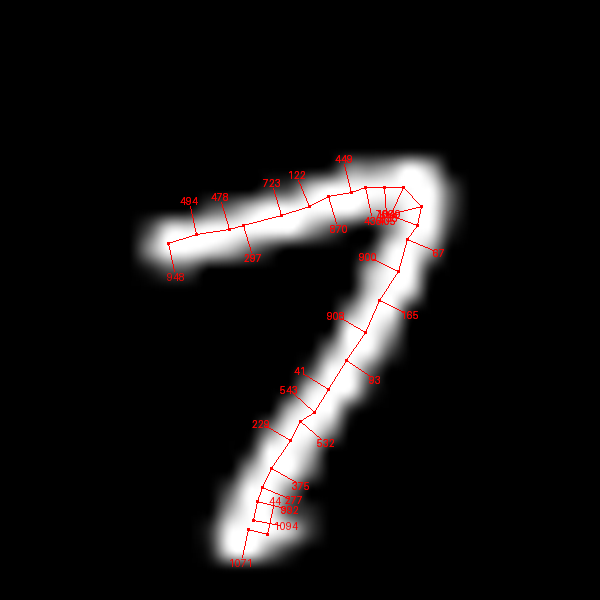

In [214]:
image_id = RNG.choice(df_image_ids.index.unique())
df_images = pd.read_sql_query('SELECT value, png, inner_si_ind_dict, outer_si_ind_dict, inner_sequences, inner_xy_sequence, inner_vec_sequence, outer_sequences FROM images WHERE image_id=:image_id', 
                                  con=train_db_con, params={'image_id': int(image_id)})
assert len(df_images) == 1
image_data = df_images.iloc[0]['png']
image = Image.open(io.BytesIO(image_data))
image2 = image.convert('RGB')
k = image2.size[0]
image2 = image2.resize((600, 600))
k = image2.size[0] / k
image_draw = ImageDraw.Draw(image2)

inner_si_ind_dict = pickle.loads(df_images.iloc[0]['inner_si_ind_dict'])
inner_sequences = pickle.loads(df_images.iloc[0]['inner_sequences'])

for seq in inner_sequences:
    for si_ind_from, si_ind_to in zip(seq, seq[1:]):
        si_from = inner_si_ind_dict[si_ind_from]
        si_to = inner_si_ind_dict[si_ind_to]
        pt_from = si_from.x * k, si_from.y * k
        pt_to = si_to.x * k, si_to.y * k
        image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')
        
        nl = 6 * k
        image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline='red')
        normal_vec = si_from.normal_vec
        image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill='red')
        image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_ind_from), anchor='mm', fill='red')

        image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline='red')
        normal_vec = si_to.normal_vec
        image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill='red')
        image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')

image2

In [194]:
image_id

np.int64(2450)